In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#from tensorflow.examples.tutorials.mnist import input_data
from torch.autograd import Variable
import sklearn.metrics as metrics
import pickle
import os
import numpy.linalg as la
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=True, download= True,
                       transform = transform)
test_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=False, download=True,
                       transform = transform)

In [3]:
batch_size = 96

In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000,shuffle=True)
print len(train_loader), len(test_loader)

625 10


In [5]:
ip_dim = 28*28
z_dim = 2
comb_dim = ip_dim + z_dim

#### Implementing BIGan

#### Encoder

In [6]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        self.l1 = nn.Linear(ip_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,500)
        self.l4 = nn.Linear(500,z_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = (self.l4(x))
        
        return x

### Decoder

In [7]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder,self).__init__()
        self.l1 = nn.Linear(z_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,500)
        self.l4 = nn.Linear(500,ip_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.tanh(self.l4(x))
        
        return x

###  Discriminator

In [8]:
class disc(nn.Module):
    def __init__(self):
        super(disc,self).__init__()
        self.l1 = nn.Linear(comb_dim,100)
        #self.l2 = nn.Linear(100,100)
        self.l3 = nn.Linear(100,50)
        self.l4 = nn.Linear(50,1)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        #x = F.leaky_relu(self.l2(x))
        x = F.elu(self.l3(x))
        x = F.sigmoid(self.l4(x))
        
        return x

In [9]:
G = decoder().cuda()
E = encoder().cuda()
D = disc().cuda()

In [10]:
def clear_grad():
    G.zero_grad()
    E.zero_grad()
    D.zero_grad()

In [11]:
E_solver = optim.Adam(E.parameters(),lr = 1e-3)
G_solver = optim.Adam(G.parameters(),lr = 1e-3)
D_solver = optim.Adam(D.parameters(),lr = 1e-3)

In [12]:
CUDA_LAUNCH_BLOCKING=1

### Start with trained encoder and decoder

In [13]:
epochs = 20
for ep in range(epochs):
    for idx,(x,label) in enumerate(train_loader):
        
        x = Variable(x.cuda())
        x = x.view(batch_size,28*28)
        z = Variable(torch.randn(batch_size,z_dim)).cuda()
        
        xhat = G(z)
        g_loss = nn.MSELoss()(xhat,x)
        g_loss.backward()
        
        G_solver.step()
        clear_grad()
        
    print g_loss.data[0]

0.268389880657
0.279769599438
0.273165017366
0.2705270648
0.264459431171
0.276143968105
0.270028889179
0.272967934608
0.261471986771
0.268736183643
0.269985169172
0.257166236639
0.262712091208
0.277432054281
0.267467588186
0.263356387615
0.254794359207
0.267885953188
0.257046669722
0.273526549339


(0.08253441751003265, 0.25629138946533203, 6.500551223754883)


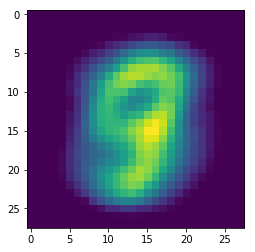

(1000,)


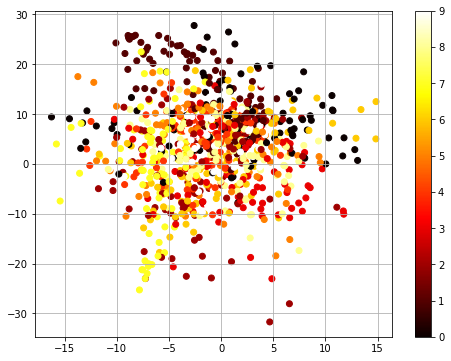

(0.08253441751003265, 0.24671383202075958, 6.664590358734131)
(0.08253441751003265, 0.24890759587287903, 5.643350124359131)
(0.019032368436455727, 0.26686209440231323, 13.34653091430664)
(0.019032368436455727, 0.2607794404029846, 12.353004455566406)
(0.019032368436455727, 0.25577762722969055, 12.803366661071777)


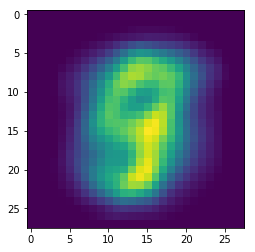

(0.0016766187036409974, 0.260440856218338, 13.056140899658203)
(0.0016766187036409974, 0.26492685079574585, 11.779515266418457)
(0.0016766187036409974, 0.26991578936576843, 12.012191772460938)
(0.0006464348407462239, 0.26192083954811096, 12.499218940734863)
(0.0006464348407462239, 0.26369965076446533, 10.877513885498047)


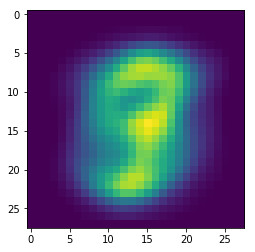

(1000,)


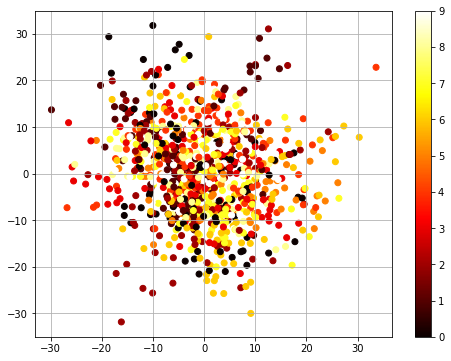

(0.0006464348407462239, 0.25899896025657654, 11.317425727844238)
(0.0062724146991968155, 0.2652471959590912, 14.853446006774902)
(0.0062724146991968155, 0.2589041292667389, 14.948925971984863)
(0.0062724146991968155, 0.25906577706336975, 14.011116981506348)
(0.00035295821726322174, 0.2547151744365692, 16.947439193725586)


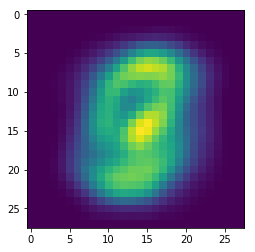

(0.00035295821726322174, 0.26016536355018616, 17.068466186523438)
(0.00035295821726322174, 0.2588968873023987, 17.077627182006836)
(0.002971061272546649, 0.2767636179924011, 13.531925201416016)
(0.002971061272546649, 0.2439848929643631, 13.496001243591309)
(0.002971061272546649, 0.24754992127418518, 13.015259742736816)


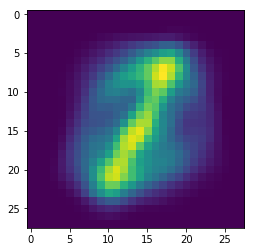

(1000,)


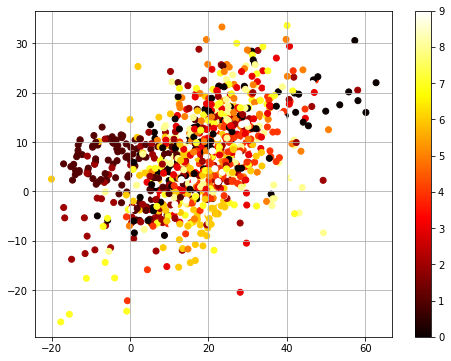

(0.008947928436100483, 0.25383538007736206, 14.048538208007812)
(0.008947928436100483, 0.25992003083229065, 12.875746726989746)
(0.008947928436100483, 0.26215660572052, 14.30513858795166)
(0.000608640315476805, 0.2784300744533539, 16.61185646057129)
(0.000608640315476805, 0.27296748757362366, 16.71910858154297)


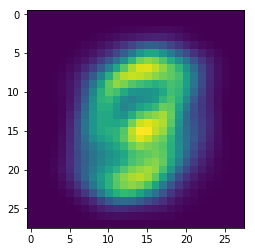

(0.000608640315476805, 0.2618453800678253, 17.27403450012207)
(0.0006729925516992807, 0.257358580827713, 17.036447525024414)
(0.0006729925516992807, 0.24851293861865997, 17.152185440063477)
(0.0006729925516992807, 0.253728985786438, 16.783300399780273)
(0.00019502162467688322, 0.2623870372772217, 18.825389862060547)


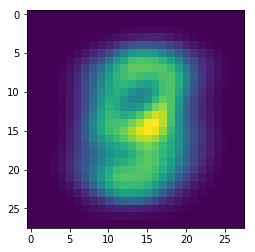

(1000,)


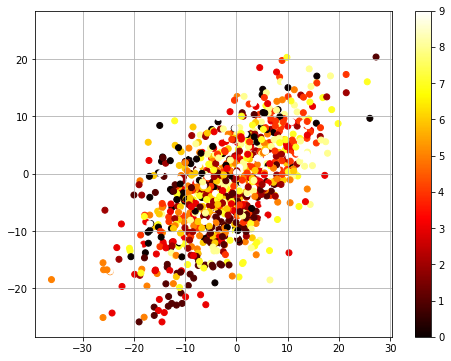

(0.00019502162467688322, 0.25832071900367737, 18.616811752319336)
(0.00019502162467688322, 0.24492165446281433, 18.833349227905273)
(0.0004011420242022723, 0.2694036662578583, 18.999309539794922)
(0.0004011420242022723, 0.2779961824417114, 18.80373191833496)
(0.0004011420242022723, 0.26252618432044983, 18.84330177307129)


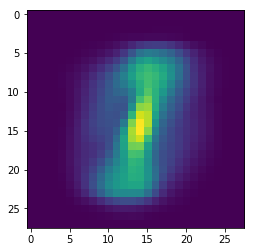

(0.01596318930387497, 0.25817352533340454, 17.340970993041992)
(0.01596318930387497, 0.2681986391544342, 17.403100967407227)
(0.01596318930387497, 0.25782907009124756, 17.053987503051758)
(0.04800787568092346, 0.26783183217048645, 17.565330505371094)
(0.04800787568092346, 0.25002872943878174, 16.964324951171875)


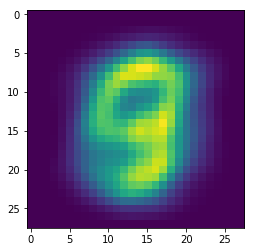

(1000,)


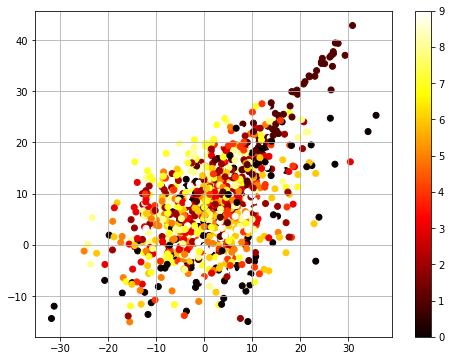

(0.04800787568092346, 0.2566074728965759, 16.970279693603516)
(0.0002233022969448939, 0.25156474113464355, 16.773229598999023)
(0.0002233022969448939, 0.26564496755599976, 16.345016479492188)
(0.0002233022969448939, 0.25142914056777954, 15.995078086853027)
(4.747869024868123e-05, 0.26434555649757385, 14.88754940032959)


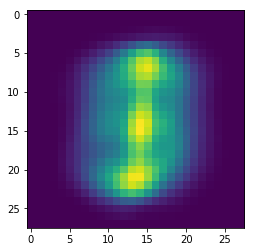

(4.747869024868123e-05, 0.2540046274662018, 15.159167289733887)
(4.747869024868123e-05, 0.2627917528152466, 14.45986557006836)
(2.9975924917380325e-05, 0.2475636750459671, 16.202613830566406)
(2.9975924917380325e-05, 0.23670995235443115, 16.443584442138672)
(2.9975924917380325e-05, 0.25725746154785156, 16.980016708374023)


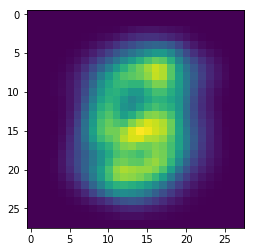

(1000,)


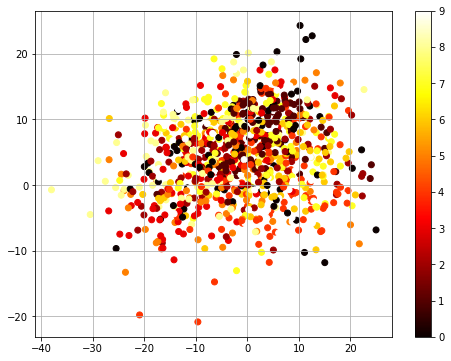

(0.05988113209605217, 0.24925805628299713, 8.465371131896973)
(0.05988113209605217, 0.268673837184906, 9.78685474395752)
(0.05988113209605217, 0.26724910736083984, 9.791605949401855)
(2.1052810552646406e-05, 0.26327937841415405, 15.232705116271973)
(2.1052810552646406e-05, 0.26759013533592224, 15.085350036621094)


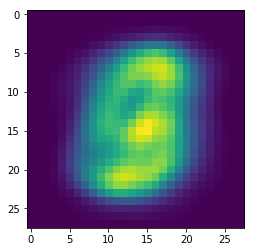

(2.1052810552646406e-05, 0.26108378171920776, 15.310206413269043)
(0.0002040229010162875, 0.2494661509990692, 15.30740737915039)
(0.0002040229010162875, 0.2577909231185913, 14.742396354675293)
(0.0002040229010162875, 0.2608737349510193, 15.15015697479248)
(0.0017801789799705148, 0.2649049758911133, 14.940011024475098)


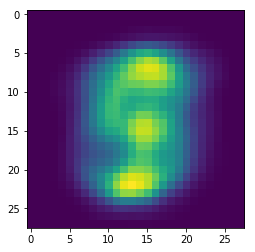

(1000,)


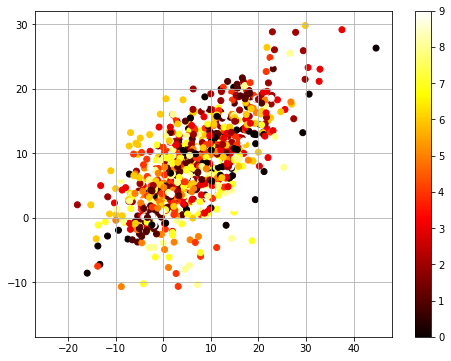

(0.0017801789799705148, 0.2561732530593872, 14.894335746765137)
(0.0017801789799705148, 0.2575143575668335, 15.18592357635498)
(0.0004807394871022552, 0.258691668510437, 13.817402839660645)
(0.0004807394871022552, 0.2583693265914917, 14.344342231750488)
(0.0004807394871022552, 0.25190505385398865, 13.939013481140137)


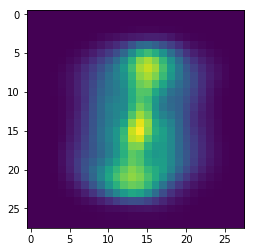

(0.0005847368738614023, 0.2718852758407593, 15.908844947814941)
(0.0005847368738614023, 0.2579936981201172, 16.40583038330078)
(0.0005847368738614023, 0.24552308022975922, 15.708297729492188)
(0.0012887789634987712, 0.27293112874031067, 11.495100975036621)
(0.0012887789634987712, 0.24428635835647583, 11.21490478515625)


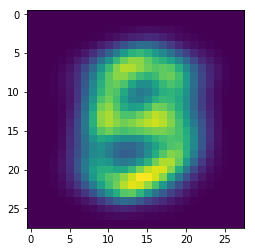

(1000,)


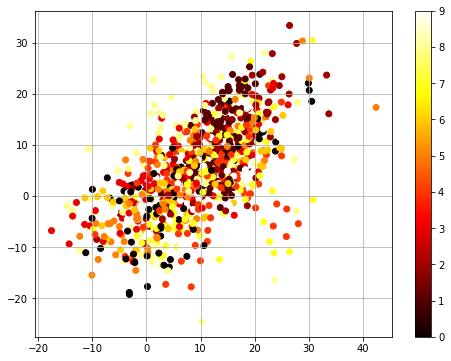

(0.0012887789634987712, 0.25373029708862305, 11.933741569519043)
(9.160301851807162e-05, 0.24718566238880157, 12.376191139221191)
(9.160301851807162e-05, 0.23840241134166718, 12.331852912902832)
(9.160301851807162e-05, 0.24167300760746002, 12.381343841552734)
(0.0002767529513221234, 0.27047595381736755, 13.381705284118652)


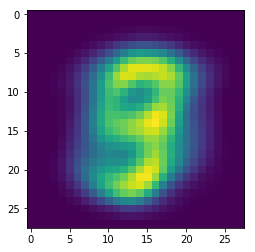

(0.0002767529513221234, 0.2425903081893921, 13.16974925994873)
(0.0002767529513221234, 0.2533032298088074, 13.189094543457031)
(0.00019949676061514765, 0.2689812183380127, 12.898189544677734)
(0.00019949676061514765, 0.2480001151561737, 13.290032386779785)
(0.00019949676061514765, 0.25628677010536194, 13.08096694946289)


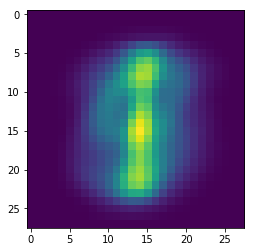

(1000,)


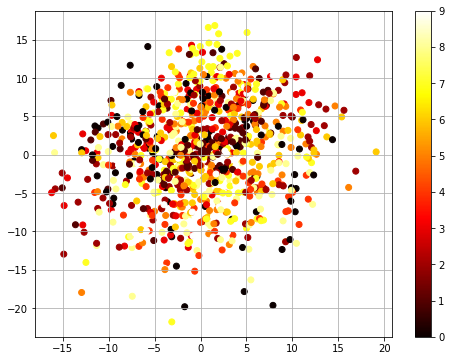

(0.0006064762710593641, 0.2647111415863037, 11.501818656921387)
(0.0006064762710593641, 0.25923651456832886, 11.481888771057129)
(0.0006064762710593641, 0.25812479853630066, 10.919087409973145)
(0.0001880881463875994, 0.2596880793571472, 12.49777603149414)
(0.0001880881463875994, 0.2621539831161499, 13.636528015136719)


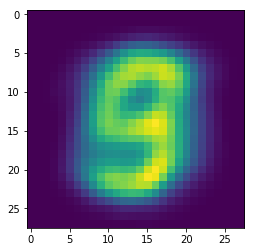

(0.0001880881463875994, 0.25596871972084045, 13.46004867553711)
(0.005398264620453119, 0.25490105152130127, 10.806190490722656)
(0.005398264620453119, 0.26315832138061523, 11.108380317687988)
(0.005398264620453119, 0.243930846452713, 10.928829193115234)
(0.0003789924958255142, 0.24957555532455444, 13.11255168914795)


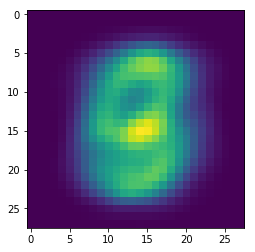

(1000,)


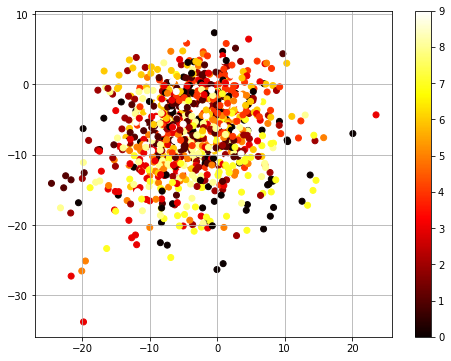

(0.0003789924958255142, 0.2413988709449768, 13.233744621276855)
(0.0003789924958255142, 0.2531929016113281, 13.361163139343262)
(0.00010417830344522372, 0.2612344026565552, 14.152838706970215)
(0.00010417830344522372, 0.24890132248401642, 14.623310089111328)
(0.00010417830344522372, 0.25334274768829346, 13.666172981262207)


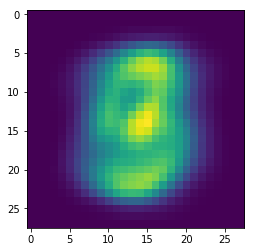

(5.51221746718511e-05, 0.2475387156009674, 15.943534851074219)
(5.51221746718511e-05, 0.26493364572525024, 16.07146644592285)
(5.51221746718511e-05, 0.24358700215816498, 15.995536804199219)
(0.0006401234422810376, 0.2598726749420166, 15.024365425109863)
(0.0006401234422810376, 0.23163636028766632, 15.378517150878906)


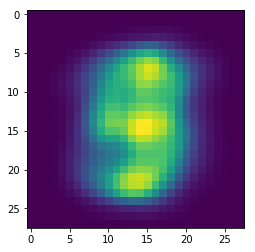

(1000,)


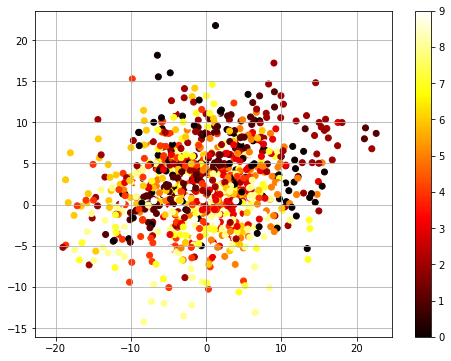

(0.0006401234422810376, 0.25964653491973877, 15.846729278564453)
(0.00020238860452082008, 0.2674330472946167, 13.693243980407715)
(0.00020238860452082008, 0.25353479385375977, 13.204059600830078)
(0.00020238860452082008, 0.24376142024993896, 12.709649085998535)
(0.03549518808722496, 0.25414106249809265, 16.01304054260254)


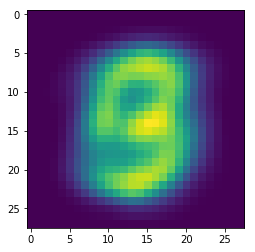

(0.03549518808722496, 0.25362348556518555, 14.41788101196289)
(0.03549518808722496, 0.2756026089191437, 14.00838565826416)
(0.0007578965742141008, 0.27639251947402954, 10.55307674407959)
(0.0007578965742141008, 0.2519418001174927, 10.777514457702637)
(0.0007578965742141008, 0.26100510358810425, 9.892407417297363)


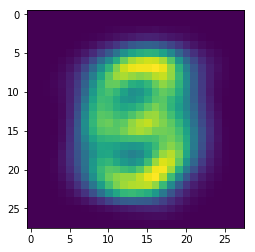

(1000,)


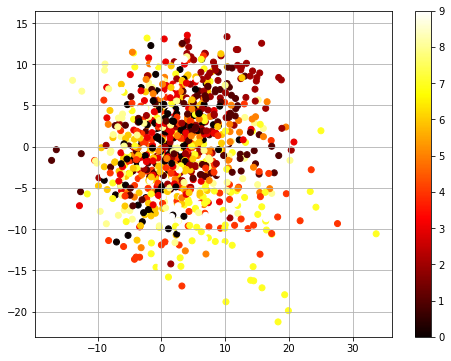

(7.085051493049832e-06, 0.2596977949142456, 15.491459846496582)
(7.085051493049832e-06, 0.27037784457206726, 16.08884620666504)
(7.085051493049832e-06, 0.26796185970306396, 15.90485668182373)
(8.528680336894467e-05, 0.2681160867214203, 12.62839412689209)
(8.528680336894467e-05, 0.2695745825767517, 12.740341186523438)


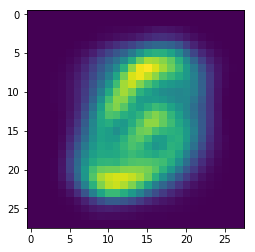

(8.528680336894467e-05, 0.25488030910491943, 12.7979097366333)
(5.1562554290285334e-05, 0.26008135080337524, 15.068327903747559)
(5.1562554290285334e-05, 0.2460002303123474, 14.688713073730469)
(5.1562554290285334e-05, 0.2308371216058731, 14.86566162109375)
(1.9363384126336314e-05, 0.25193315744400024, 16.590187072753906)


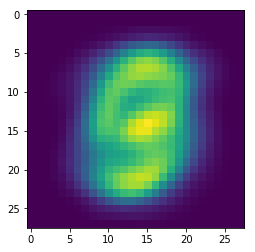

(1000,)


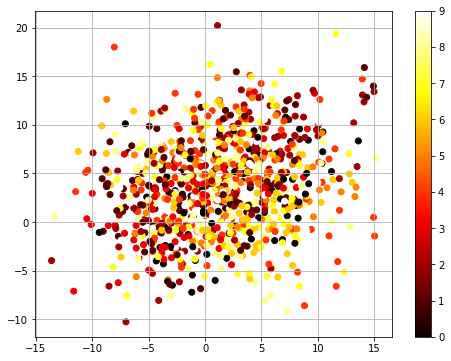

(1.9363384126336314e-05, 0.2520901560783386, 16.072431564331055)
(1.9363384126336314e-05, 0.2537634074687958, 16.87726402282715)
(0.0006150610279291868, 0.2542400360107422, 13.593358039855957)
(0.0006150610279291868, 0.24534134566783905, 13.652718544006348)
(0.0006150610279291868, 0.2543865144252777, 13.31878662109375)


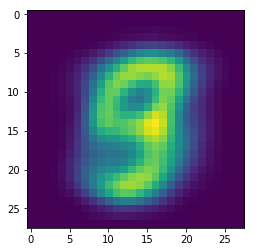

(0.0003009469073731452, 0.2616475224494934, 10.782966613769531)
(0.0003009469073731452, 0.24408042430877686, 10.551362991333008)
(0.0003009469073731452, 0.2639968991279602, 11.040131568908691)
(0.006967171560972929, 0.248966246843338, 14.855807304382324)
(0.006967171560972929, 0.23578228056430817, 13.465729713439941)


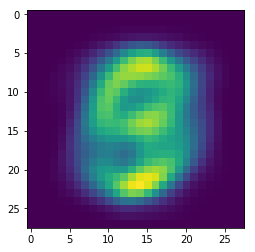

(1000,)


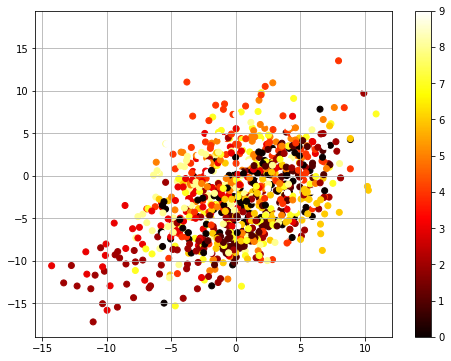

(0.006967171560972929, 0.25189536809921265, 13.47103214263916)
(0.0031256501097232103, 0.27387315034866333, 12.868260383605957)
(0.0031256501097232103, 0.26126641035079956, 13.240402221679688)
(0.0031256501097232103, 0.2506921589374542, 13.171223640441895)
(9.540742030367255e-05, 0.25110626220703125, 14.055556297302246)


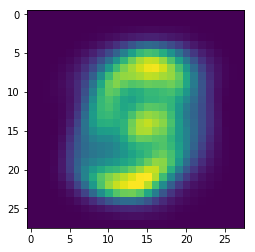

(9.540742030367255e-05, 0.2573550045490265, 14.494033813476562)
(9.540742030367255e-05, 0.23947063088417053, 14.853046417236328)
(0.000941393431276083, 0.26120221614837646, 15.597001075744629)
(0.000941393431276083, 0.2575860917568207, 14.277763366699219)
(0.000941393431276083, 0.25815051794052124, 14.319403648376465)


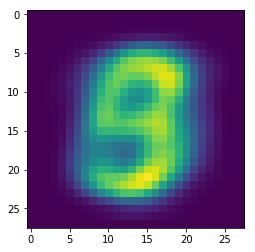

(1000,)


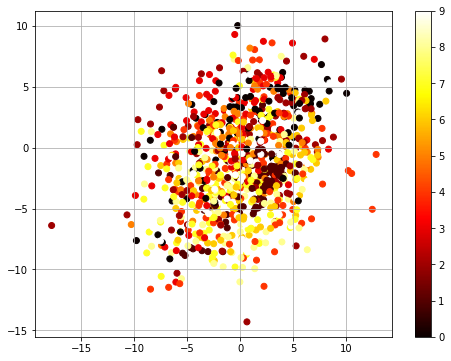

(0.001722595188766718, 0.252491295337677, 8.41091251373291)
(0.001722595188766718, 0.23114168643951416, 9.331438064575195)
(0.001722595188766718, 0.2514403462409973, 9.137715339660645)
(0.00014788696717005223, 0.26533034443855286, 13.973389625549316)
(0.00014788696717005223, 0.26119017601013184, 14.021414756774902)


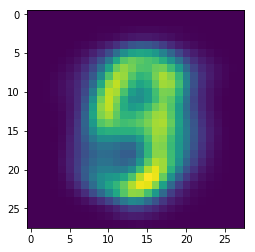

(0.00014788696717005223, 0.2577575445175171, 13.929024696350098)
(7.027358515188098e-05, 0.25081226229667664, 13.173161506652832)
(7.027358515188098e-05, 0.25618988275527954, 13.278580665588379)
(7.027358515188098e-05, 0.26784011721611023, 14.2756986618042)
(1.9984365280834027e-05, 0.2503008544445038, 16.941247940063477)


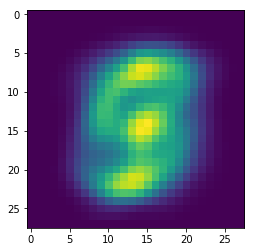

(1000,)


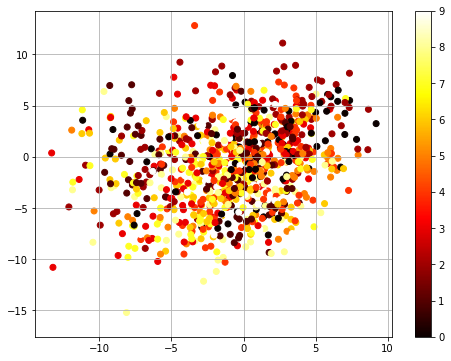

(1.9984365280834027e-05, 0.2532735764980316, 16.557748794555664)
(1.9984365280834027e-05, 0.2718365490436554, 16.836254119873047)
(0.00018217724573332816, 0.2559795379638672, 11.932075500488281)
(0.00018217724573332816, 0.24469931423664093, 11.899748802185059)
(0.00018217724573332816, 0.2585507333278656, 12.515392303466797)


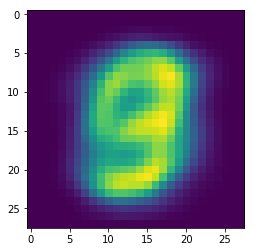

(0.009378965944051743, 0.2631779611110687, 15.327242851257324)
(0.009378965944051743, 0.25143179297447205, 15.013648986816406)
(0.009378965944051743, 0.2577238380908966, 15.687183380126953)
(8.882002293830737e-05, 0.23848140239715576, 14.94808578491211)
(8.882002293830737e-05, 0.23363851010799408, 14.160804748535156)


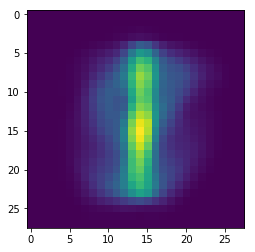

(1000,)


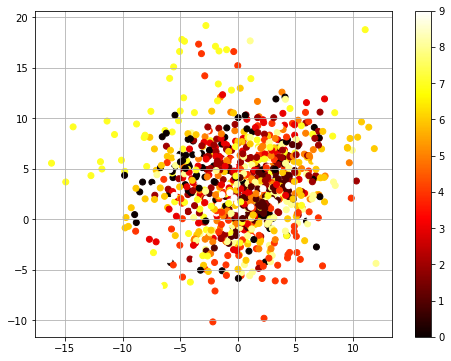

(8.882002293830737e-05, 0.25692376494407654, 14.729389190673828)
(0.00023838609922677279, 0.25384512543678284, 12.74393081665039)
(0.00023838609922677279, 0.2318975031375885, 12.84057903289795)
(0.00023838609922677279, 0.21453142166137695, 13.00464153289795)
(0.0016619771486148238, 0.25215110182762146, 11.716148376464844)


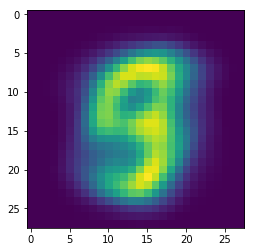

(0.0016619771486148238, 0.24439449608325958, 11.303810119628906)
(0.0016619771486148238, 0.23825815320014954, 11.759276390075684)
(0.004712490830570459, 0.24638675153255463, 10.747523307800293)
(0.004712490830570459, 0.24055764079093933, 10.705143928527832)
(0.004712490830570459, 0.23569628596305847, 10.76826000213623)


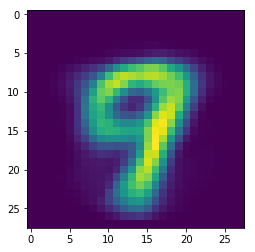

(1000,)


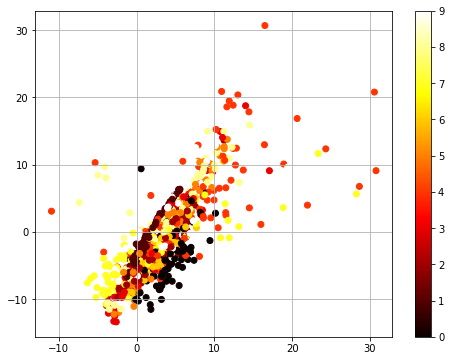

(0.00028950764681212604, 0.2228652983903885, 13.348689079284668)
(0.00028950764681212604, 0.21683426201343536, 13.10356616973877)
(0.00028950764681212604, 0.2091268002986908, 12.652070045471191)
(0.00030409786268137395, 0.2592248320579529, 15.429954528808594)
(0.00030409786268137395, 0.260414183139801, 14.443772315979004)


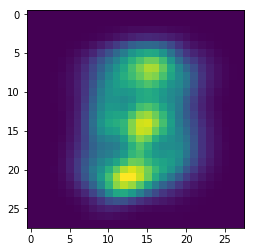

(0.00030409786268137395, 0.25452715158462524, 14.66626262664795)
(0.00012114347919123247, 0.27568724751472473, 16.532222747802734)
(0.00012114347919123247, 0.25370824337005615, 17.27132225036621)
(0.00012114347919123247, 0.24175623059272766, 15.879794120788574)
(4.8852638428797945e-05, 0.25343430042266846, 13.944717407226562)


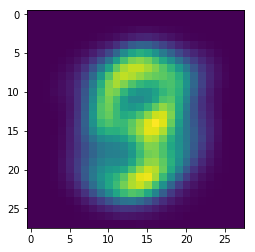

(1000,)


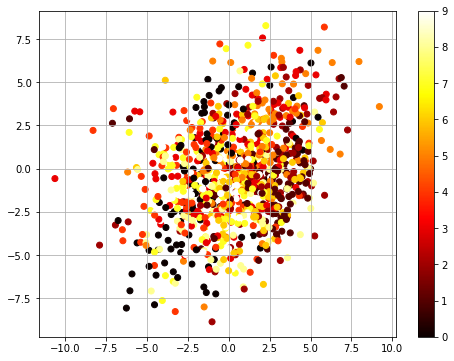

(4.8852638428797945e-05, 0.25322479009628296, 13.212613105773926)
(4.8852638428797945e-05, 0.24951405823230743, 13.463438987731934)
(1.8261600416735746e-05, 0.24132058024406433, 15.852734565734863)
(1.8261600416735746e-05, 0.25981399416923523, 15.963440895080566)
(1.8261600416735746e-05, 0.2402103692293167, 16.117340087890625)


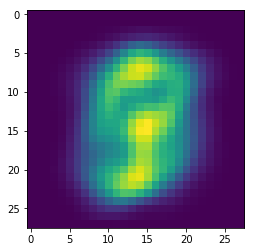

(2.93207212962443e-05, 0.2621507942676544, 13.968429565429688)
(2.93207212962443e-05, 0.2286921888589859, 12.524828910827637)
(2.93207212962443e-05, 0.24857375025749207, 13.290225982666016)
(0.0006380413542501628, 0.26204901933670044, 11.569618225097656)
(0.0006380413542501628, 0.22934740781784058, 10.679957389831543)


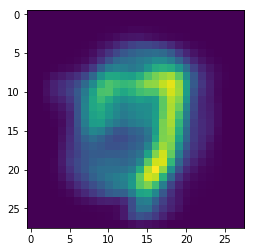

(1000,)


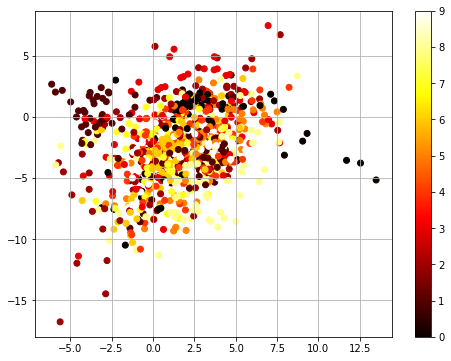

(0.0006380413542501628, 0.24349583685398102, 11.193110466003418)
(0.002659391611814499, 0.25314629077911377, 17.652671813964844)
(0.002659391611814499, 0.2468530833721161, 17.032690048217773)
(0.002659391611814499, 0.24282459914684296, 18.061214447021484)
(0.00023929782037157565, 0.2550443708896637, 14.509198188781738)


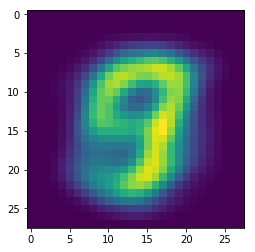

(0.00023929782037157565, 0.22293570637702942, 14.594897270202637)
(0.00023929782037157565, 0.21981500089168549, 14.53582763671875)
(0.028578726574778557, 0.2498272955417633, 15.000981330871582)
(0.028578726574778557, 0.2446460872888565, 14.291221618652344)
(0.028578726574778557, 0.25531062483787537, 13.843727111816406)


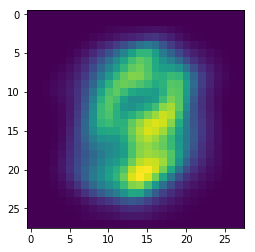

(1000,)


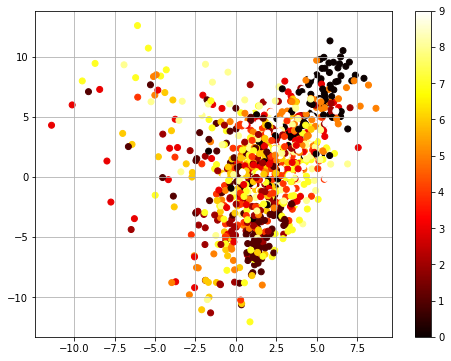

(1.912964762595948e-06, 0.24947987496852875, 17.069398880004883)
(1.912964762595948e-06, 0.26485103368759155, 17.744457244873047)
(1.912964762595948e-06, 0.2716800272464752, 16.543926239013672)
(0.03412012383341789, 0.24347637593746185, 14.137633323669434)
(0.03412012383341789, 0.23529104888439178, 14.495353698730469)


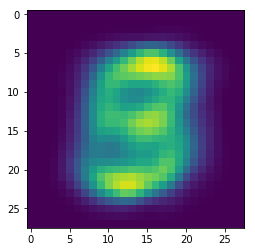

(0.03412012383341789, 0.2307397723197937, 15.132208824157715)
(0.05125707387924194, 0.2492164820432663, 9.403347969055176)
(0.05125707387924194, 0.22098614275455475, 9.062394142150879)
(0.05125707387924194, 0.20328429341316223, 8.123892784118652)
(0.00010349430522182956, 0.22463670372962952, 16.367525100708008)


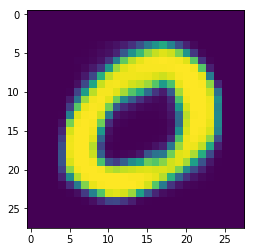

(1000,)


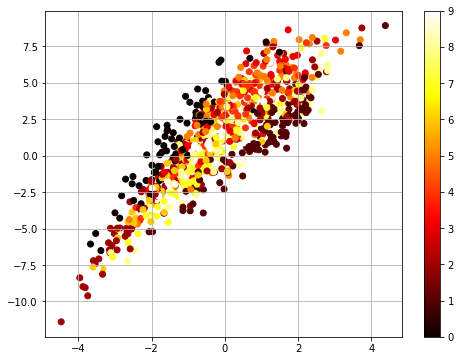

(0.00010349430522182956, 0.21455757319927216, 16.223814010620117)
(0.00010349430522182956, 0.2006547898054123, 16.28287696838379)
(0.003163994289934635, 0.2038811296224594, 12.262019157409668)
(0.003163994289934635, 0.1991373896598816, 11.653800964355469)
(0.003163994289934635, 0.21135972440242767, 12.236591339111328)


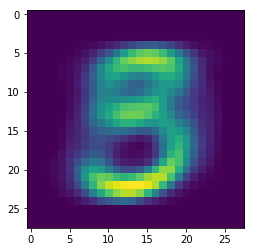

(0.0008988222689367831, 0.2015315145254135, 16.294036865234375)
(0.0008988222689367831, 0.2040165215730667, 16.98952293395996)
(0.0008988222689367831, 0.23326334357261658, 16.655258178710938)
(0.0007759439176879823, 0.21665823459625244, 14.100635528564453)
(0.0007759439176879823, 0.22114171087741852, 14.528133392333984)


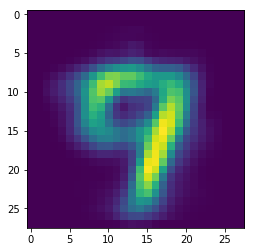

(1000,)


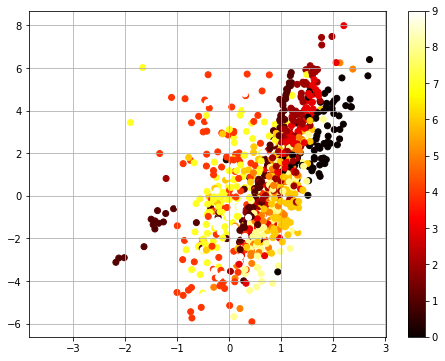

(0.0007759439176879823, 0.21754691004753113, 14.987627983093262)
(0.0006068213260732591, 0.20654655992984772, 15.516291618347168)
(0.0006068213260732591, 0.2288159728050232, 15.39992618560791)
(0.0006068213260732591, 0.21047662198543549, 15.177990913391113)
(0.0004302910529077053, 0.21366046369075775, 16.608299255371094)


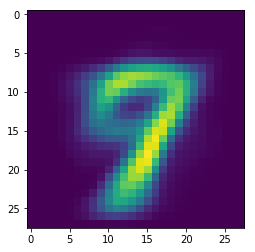

(0.0004302910529077053, 0.21401028335094452, 16.680234909057617)
(0.0004302910529077053, 0.20777040719985962, 16.414770126342773)
(0.0043190554715693, 0.21715962886810303, 15.283209800720215)
(0.0043190554715693, 0.21154695749282837, 14.935893058776855)
(0.0043190554715693, 0.20354804396629333, 14.844462394714355)


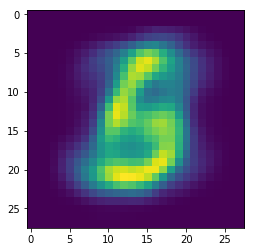

(1000,)


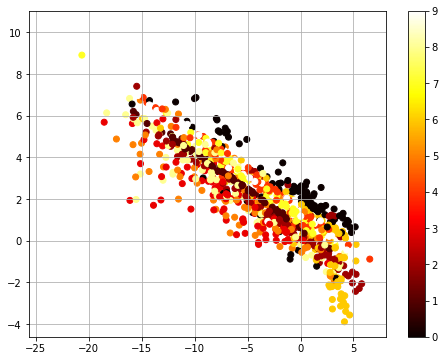

(0.007761379238218069, 0.2190987765789032, 16.31487464904785)
(0.007761379238218069, 0.2109684944152832, 15.700942039489746)
(0.007761379238218069, 0.2077743262052536, 16.6450252532959)
(0.0002481207193341106, 0.21615640819072723, 16.001718521118164)
(0.0002481207193341106, 0.2074621617794037, 16.482723236083984)


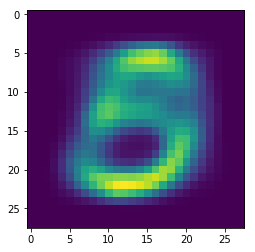

(0.0002481207193341106, 0.21756303310394287, 16.179216384887695)
(1.8903028831118718e-05, 0.20471081137657166, 19.08439826965332)
(1.8903028831118718e-05, 0.22159835696220398, 18.90184211730957)
(1.8903028831118718e-05, 0.21286551654338837, 18.48111343383789)
(0.0003063265758100897, 0.21212832629680634, 13.1008882522583)


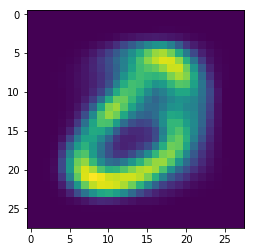

(1000,)


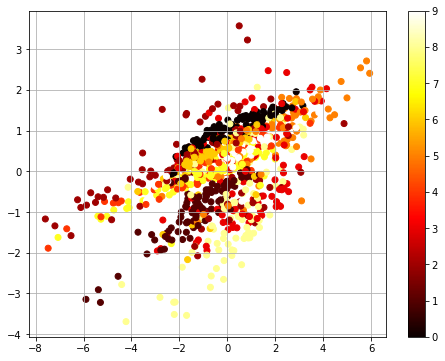

(0.0003063265758100897, 0.1973615139722824, 13.459999084472656)
(0.0003063265758100897, 0.2010510414838791, 13.401551246643066)
(0.000115274939162191, 0.221968874335289, 19.146974563598633)
(0.000115274939162191, 0.2083347886800766, 18.370359420776367)
(0.000115274939162191, 0.21095986664295197, 17.772768020629883)


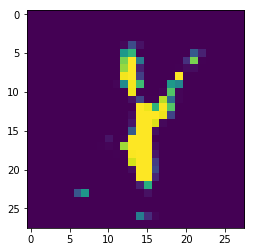

(0.0009153448627330363, 0.22622384130954742, 17.991989135742188)
(0.0009153448627330363, 0.2156815081834793, 17.33481788635254)
(0.0009153448627330363, 0.2178472876548767, 18.610612869262695)
(0.0008636466227471828, 0.2256426364183426, 15.501167297363281)
(0.0008636466227471828, 0.23921655118465424, 15.45460033416748)


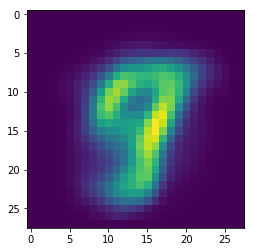

(1000,)


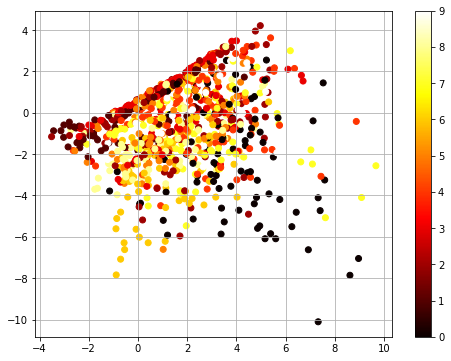

(0.0008636466227471828, 0.24282081425189972, 15.735507011413574)
(0.003008931642398238, 0.24069099128246307, 12.77703857421875)
(0.003008931642398238, 0.2483796626329422, 12.759979248046875)
(0.003008931642398238, 0.2592736482620239, 12.668150901794434)
(0.00022719382832292467, 0.2397579848766327, 13.104408264160156)


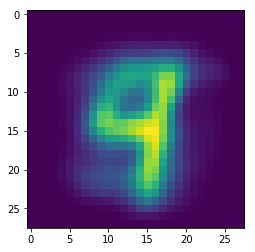

(0.00022719382832292467, 0.23648768663406372, 13.168140411376953)
(0.00022719382832292467, 0.23919422924518585, 12.635834693908691)
(0.0003720433742273599, 0.2629464864730835, 13.570235252380371)
(0.0003720433742273599, 0.2567744851112366, 14.11637020111084)
(0.0003720433742273599, 0.25680240988731384, 13.739090919494629)


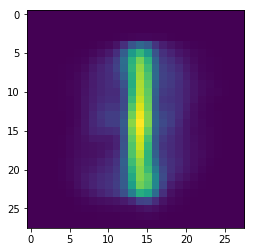

(1000,)


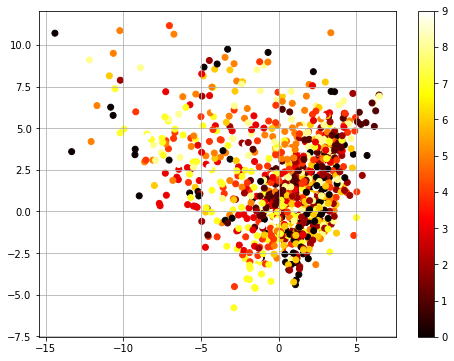

(0.00011923513375222683, 0.2553557753562927, 15.302700996398926)
(0.00011923513375222683, 0.24380077421665192, 15.602606773376465)
(0.00011923513375222683, 0.2427237182855606, 15.411018371582031)
(0.00023133154900278896, 0.2537507712841034, 15.750256538391113)
(0.00023133154900278896, 0.2527037262916565, 14.681167602539062)


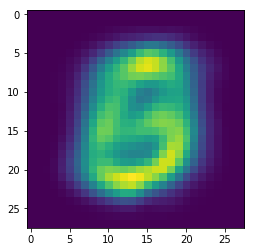

(0.00023133154900278896, 0.2341160923242569, 15.2450590133667)
(0.0012646695831790566, 0.2443125993013382, 9.861700057983398)
(0.0012646695831790566, 0.2127705067396164, 9.80140209197998)
(0.0012646695831790566, 0.2089865505695343, 9.784367561340332)
(0.0003429179487284273, 0.23961877822875977, 13.224933624267578)


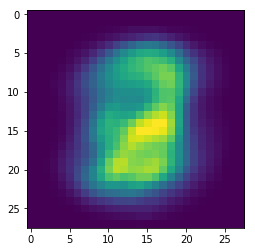

(1000,)


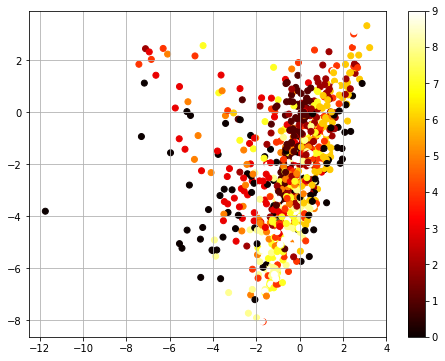

(0.0003429179487284273, 0.23989321291446686, 13.724761009216309)
(0.0003429179487284273, 0.21756303310394287, 12.515320777893066)
(0.00038366063381545246, 0.2308240383863449, 13.017585754394531)
(0.00038366063381545246, 0.21514776349067688, 12.859203338623047)
(0.00038366063381545246, 0.20641422271728516, 13.101367950439453)


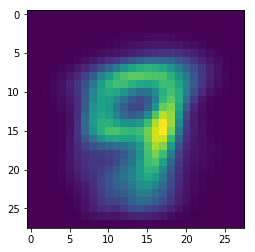

(7.271322829183191e-05, 0.21635282039642334, 14.014046669006348)
(7.271322829183191e-05, 0.2130773365497589, 13.420731544494629)
(7.271322829183191e-05, 0.21567821502685547, 13.224827766418457)
(0.00029293791158124804, 0.21586968004703522, 14.928821563720703)
(0.00029293791158124804, 0.21154040098190308, 14.654141426086426)


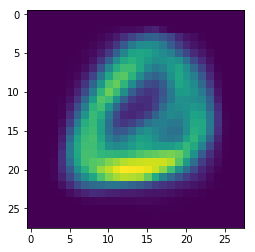

(1000,)


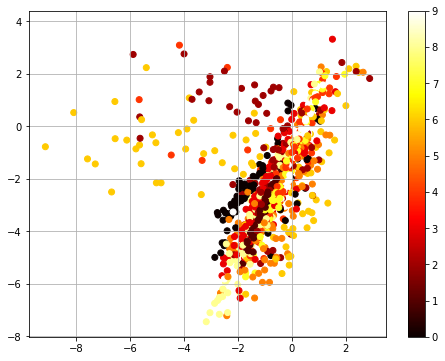

(0.00029293791158124804, 0.2258501946926117, 15.053970336914062)
(0.008849778212606907, 0.2311735600233078, 10.642193794250488)
(0.008849778212606907, 0.22623388469219208, 11.16806697845459)
(0.008849778212606907, 0.20344246923923492, 10.429511070251465)
(0.000757874280679971, 0.21915049850940704, 14.284533500671387)


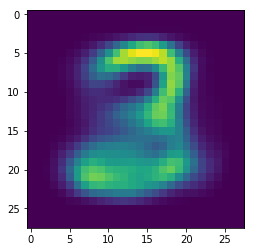

(0.000757874280679971, 0.20215243101119995, 14.208025932312012)
(0.000757874280679971, 0.20555397868156433, 14.594840049743652)
(0.002004156121984124, 0.20492199063301086, 10.823151588439941)
(0.002004156121984124, 0.2185741811990738, 10.595987319946289)
(0.002004156121984124, 0.21944934129714966, 10.896858215332031)


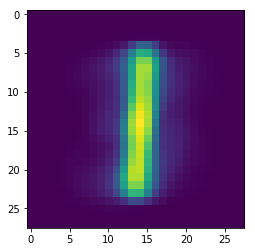

(1000,)


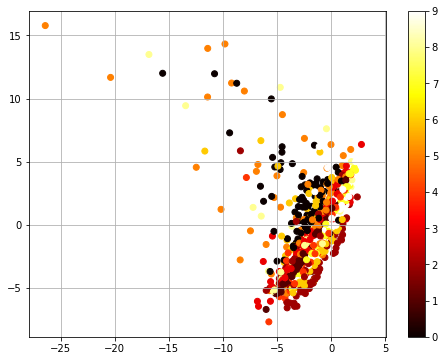

(0.00037431195960380137, 0.2153359353542328, 19.138004302978516)
(0.00037431195960380137, 0.1964074969291687, 19.19151496887207)
(0.00037431195960380137, 0.20386415719985962, 19.047758102416992)
(0.00022224891290534288, 0.20604033768177032, 14.641258239746094)
(0.00022224891290534288, 0.21692271530628204, 14.346667289733887)


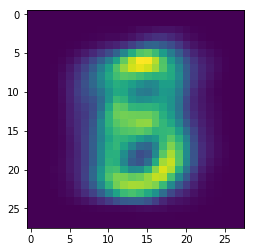

(0.00022224891290534288, 0.21038195490837097, 14.550566673278809)
(2.8256477889954112e-05, 0.21499167382717133, 16.14588737487793)
(2.8256477889954112e-05, 0.21885068714618683, 14.995723724365234)
(2.8256477889954112e-05, 0.187571182847023, 15.538859367370605)
(0.0020719689782708883, 0.25484663248062134, 11.01562213897705)


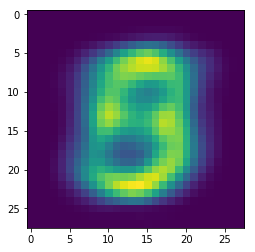

(1000,)


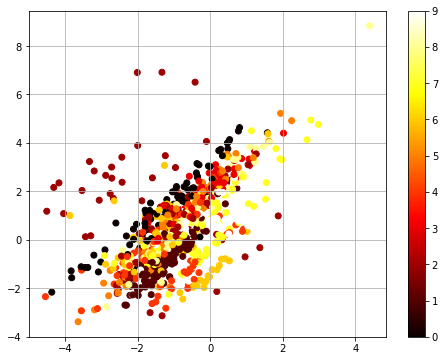

(0.0020719689782708883, 0.21140435338020325, 11.674700736999512)
(0.0020719689782708883, 0.21210269629955292, 11.203450202941895)
(0.0012959452578797936, 0.23218059539794922, 16.875856399536133)
(0.0012959452578797936, 0.2179756909608841, 19.092041015625)
(0.0012959452578797936, 0.21320074796676636, 18.925941467285156)


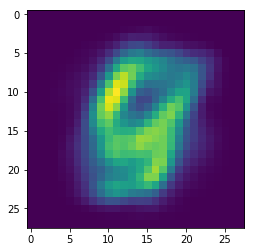

(8.60693326103501e-05, 0.24013683199882507, 17.18853759765625)
(8.60693326103501e-05, 0.23021894693374634, 17.16554069519043)
(8.60693326103501e-05, 0.24051697552204132, 16.79591941833496)
(0.00272008846513927, 0.24085484445095062, 12.2204008102417)
(0.00272008846513927, 0.24396109580993652, 12.109877586364746)


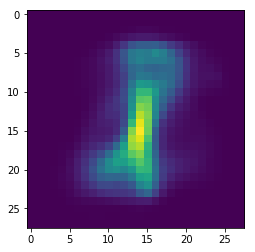

(1000,)


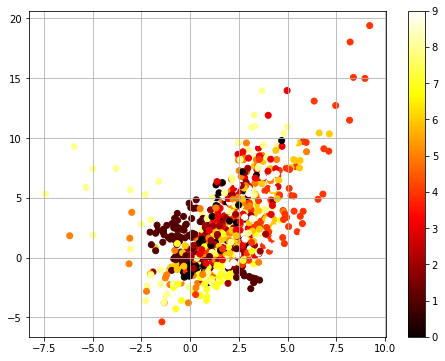

(0.00272008846513927, 0.23325495421886444, 12.12619686126709)
(0.00022260424157138914, 0.21947653591632843, 15.964984893798828)
(0.00022260424157138914, 0.22194451093673706, 16.775375366210938)
(0.00022260424157138914, 0.22996002435684204, 15.606026649475098)
(0.022750424221158028, 0.22698739171028137, 14.482522010803223)


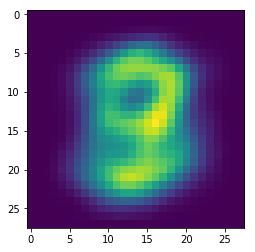

(0.022750424221158028, 0.2281244993209839, 16.024322509765625)


KeyboardInterrupt: 

In [14]:
epochs = 1000
for ep in range(epochs):
    for i,(x,label) in enumerate(train_loader):
        
        x = Variable(x.cuda())
        x = x.view(batch_size,28*28)
    
        
        z = Variable(torch.randn(batch_size,z_dim)).cuda()
        
        zhat = E(x)
        xhat = G(zhat)
        
        
       
        add_tiny = 1e-10        

        
#         t_label = Variable(torch.ones(d_true.size()).cuda())
#         f_label = Variable(torch.zeros(d_true.size()).cuda())
        
        ## autoencoder loss ##
        
        gen_loss = nn.MSELoss()(xhat,x)
        gen_loss.backward(retain_graph= True)
        G_solver.step()
        E_solver.step()
        clear_grad()
        
        ## Encoder has to fool the disc ##
        
        zhat = E(x)
        v1 = torch.cat([x,zhat],1)
        d_false = D(v1)
        enc_loss = -torch.mean(torch.log(d_false + add_tiny))
        enc_loss.backward(retain_graph= True)
        E_solver.step()
        clear_grad()
        
        ## Discriminator loss ##
        
       
        
        if(ep%3==0):
           
            zhat = E(x)
            v1 = torch.cat([x,zhat],1)
            v2 = torch.cat([xhat,z],1)
            
            d_false = D(v1)
            d_true = D(v2)            
            
            disc_loss = -torch.mean(torch.log(d_true + add_tiny) + torch.log((1-d_false) + add_tiny))
            disc_loss.backward()
            D_solver.step()
            clear_grad()       
   
        ### Updating the generator and the encoder ###
        
       
        
       
        
    ## print loss ##
    
    if(ep%1==0):
        print(disc_loss.data[0],gen_loss.data[0],enc_loss.data[0])
        
    ## show generated images ##
    if(ep%5==0):
        z_check = Variable(torch.randn(1,z_dim)).cuda()
        op = G(z_check).resize(28,28)
        op = op.data.cpu().numpy()
        plt.imshow(op)
        plt.show()
        
    ## show distribution ##
    
    if(ep%10==0):
        
            
        xcheck,labels = next(iter(test_loader))
        labels2 = labels.numpy()
        xcheck = Variable(xcheck.view(1000,28*28).cuda())
        zhat = E(xcheck)
        z_mu = zhat.cpu().data.numpy()
        print labels2.shape
        plt.figure(figsize=(8, 6)) 
        #colors = cm.rainbow(np.linspace(0, 1, 10))
        plt.scatter(z_mu[:, 0], z_mu[:, 1],c = labels2,cmap=plt.cm.hot)
        plt.colorbar()
        plt.grid()
        plt.show()
        
        

###  Check

In [ ]:
z_check = Variable(torch.randn(1,z_dim)).cuda()
op = G(z_check)
op = op.resize(28,28)
op = op.data.cpu().numpy()
plt.imshow(op)
plt.show()

In [ ]:
if(1==1):
    xcheck,labels = next(iter(test_loader))
    labels2 = labels.numpy()
    xcheck = Variable(xcheck.view(1000,28*28).cuda())
    zhat = E(xcheck)
    z_mu = zhat.cpu().data.numpy()
    print labels2.shape
    plt.figure(figsize=(8, 6)) 
    #colors = cm.rainbow(np.linspace(0, 1, 10))
    plt.scatter(z_mu[:, 0], z_mu[:, 1],c = labels2,cmap=plt.cm.hot)
    plt.colorbar()
    plt.grid()
    plt.show()